## Answer 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import mixture
from sklearn.model_selection import KFold

In [2]:
def compute_log_likelihood(m,data):
    '''
    m is the model
    data is samples 
    '''
    return m.score(data)

In [3]:
def generate_GMM_samples(prior,number_of_samples,sig1,sig2,sig3,sig4,u1,u2,u3,u4):
    '''
    Args:
    prior of class 1 = prior[0]
    prior of class 2 = prior[1]
    prior of class 3 = prior[2]
    prior of class 4 = 1-prior[0]-prior[1]-prior[2]
    
    number_of_samples
    
    class 1- u_1, sig_1
    class 2- u_2, sig_2
    class 3- u_3, sig_3
    class 4- u_4, sig_4
    
    x is samples from zero-mean identity-covariance Gaussian sample generators

    generating class 1- A1*x+b1
    generating class 2- A2*x+b2
    generating class 3- A3*x+b3
    generating class 4- A4*x+b4
    
    '''
    from matplotlib.pyplot import figure
    #txt="Plot of data sampled from 4 gaussians "
    fig = plt.figure(figsize=(10,10));
    #fig.text(.35,0.05,txt,fontsize=15);
    
    samples_class1=[]
    samples_class2=[]
    samples_class3=[]
    samples_class4=[]
    
    sig_1=np.matrix(sig1)
    sig_2=np.matrix(sig2)
    sig_3=np.matrix(sig3)
    sig_4=np.matrix(sig4)
    
    u_1=np.matrix(u1).transpose()
    u_2=np.matrix(u2).transpose()
    u_3=np.matrix(u3).transpose()
    u_4=np.matrix(u4).transpose()
    
    prior=prior
    A1=np.linalg.cholesky(sig_1)
    b1=u_1

    A2=np.linalg.cholesky(sig_2)
    b2=u_2
    
    A3=np.linalg.cholesky(sig_3)
    b3=u_3
    
    A4=np.linalg.cholesky(sig_4)
    b4=u_4
        
    zero_mean=[0,0]
    cov=[[1,0],[0,1]]
    
    for i in range(number_of_samples):
        uniform_sample=np.random.uniform()

        sample_from_zero_mean_identity_covariance=np.random.multivariate_normal(zero_mean,cov,[1]).transpose()

        if uniform_sample<prior[0]:
            '''sample from class class 1'''
            sample=A1.dot(sample_from_zero_mean_identity_covariance)+b1
            samples_class1.append(sample)
        elif (prior[0]<uniform_sample<prior[0]+prior[1]):
            '''sample from class class 2'''
            sample=A2.dot(sample_from_zero_mean_identity_covariance)+b2
            samples_class2.append(sample)
        elif (prior[0]+prior[1]<uniform_sample<prior[0]+prior[1]+prior[2]):
            '''sample from class class 3'''
            sample=A3.dot(sample_from_zero_mean_identity_covariance)+b3
            samples_class3.append(sample)
        else :
            '''sample from class class 4'''
            sample=A4.dot(sample_from_zero_mean_identity_covariance)+b4
            samples_class4.append(sample)
                
                
    samples_class1_final=np.hstack(samples_class1)
    samples_class2_final=np.hstack(samples_class2)
    samples_class3_final=np.hstack(samples_class3)
    samples_class4_final=np.hstack(samples_class4)
    
    a=np.squeeze(np.asarray(samples_class1_final.transpose()[:,1]))
    b=np.squeeze(np.asarray(samples_class1_final.transpose()[:,0]))

    c=np.squeeze(np.asarray(samples_class2_final.transpose()[:,1]))
    d=np.squeeze(np.asarray(samples_class2_final.transpose()[:,0]))

    e=np.squeeze(np.asarray(samples_class3_final.transpose()[:,1]))
    f=np.squeeze(np.asarray(samples_class3_final.transpose()[:,0]))
    
    g=np.squeeze(np.asarray(samples_class4_final.transpose()[:,1]))
    h=np.squeeze(np.asarray(samples_class4_final.transpose()[:,0]))
    plt.xlabel('Variable x1',size=13)
    plt.ylabel('Variable x2',size=13)
    fig.suptitle('Plot of data sampled from 4 gaussians', fontsize=15)
    plt.scatter(b,a,color='r',marker='*',label='class 1',s=50)
    plt.scatter(d,c,color='g',marker='*',label='class 2',s=50)
    plt.scatter(f,e,color='b',marker='*',label='class 3',s=50)
    plt.scatter(h,g,color='y',marker='*',label='class 4',s=50)
    plt.legend(loc='best')
    #plt.show()
    
    data=np.hstack([samples_class1_final,samples_class2_final,samples_class3_final,samples_class4_final])
    '''
    data.shape=(2,samples)
    '''
    return data

In [4]:
def gmm_em_kfold(data):
    '''
    create 8 models of GMM
    '''
    n_components = np.arange(1, 9)    
    models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0)
              for n in n_components]
    '''
    Lists log_likelihood,bic,aic to store result and plot 
    '''
    log_likelihood=[]
    bic=[]
    aic=[]    
    '''
    KFold function from sklearn
    '''
    cv = KFold(n_splits=10, random_state=42, shuffle=True)
    for m in models:
        '''
        Lists scores,scores_bic,scores_aic to store 'k' scores on 'k' different validation set
        '''
        scores = []
        scores_bic=[]
        scores_aic=[]
        for train_index, test_index in cv.split(data.T):
            X_train, X_test= data.T[train_index], data.T[test_index]
            m.fit(X_train) # fit the model
            scores.append(compute_log_likelihood(m,X_test)) # find  log_likelihood on test set and add it to the list
            scores_bic.append(m.bic(X_test)) # find  bic on test set and add it to the list
            scores_aic.append(m.aic(X_test)) # find  aic on test set and add it to the list
        log_likelihood.append(-1*sum(scores)/len(scores)) # average the score over k validation sets
        bic.append(sum(scores_bic)/len(scores_bic)) # average the score over k validation sets
        aic.append(sum(scores_aic)/len(scores_aic)) # average the score over k validation sets
    from matplotlib.pyplot import figure
    fig = plt.figure(figsize=(10,10));
    plt.plot(n_components, log_likelihood, label='negative log_likelihood')
    plt.xlabel('n_components',size=13);
    plt.ylabel('score',size=13);
    plt.legend(loc='best')
    fig.suptitle('Negative log_likelihood score for different GMM models', fontsize=15)
    plt.show()
    from matplotlib.pyplot import figure
    fig = plt.figure(figsize=(10,10));
    plt.xlabel('n_components',size=13);
    plt.ylabel('score',size=13);
    plt.plot(n_components, bic, label='BIC')
    plt.plot(n_components, aic, label='AIC')
    fig.suptitle('BIC and AIC scores for different GMM models', fontsize=15)
    plt.legend(loc='best')
    plt.show()
    return 

### Answer part 1. True GMM

In [5]:
prior=[0.19,0.21,0.36,0.24]  
# prior of Gaussian 1 = prior[0]
# prior of Gaussian 2 = prior[1]
# prior of Gaussian 3 = prior[2]
# prior of Gaussian 4 = prior[3]

# mean and covariance of gaussian 1
sig1=[[.15,-.1],[.1,.15]]
u1=[-1,-1]

# mean and covariance of gaussian 2
sig2=[[.15,.1],[.1,.15]]
u2=[1,1]

# mean and covariance of gaussian 3
sig3=[[.15,.1],[-.1,.15]]
u3=[-1,1]

# mean and covariance of gaussian 4
sig4=[[.15,.1],[-.1,.15]]
u4=[1,-1]




Number of samples:  10






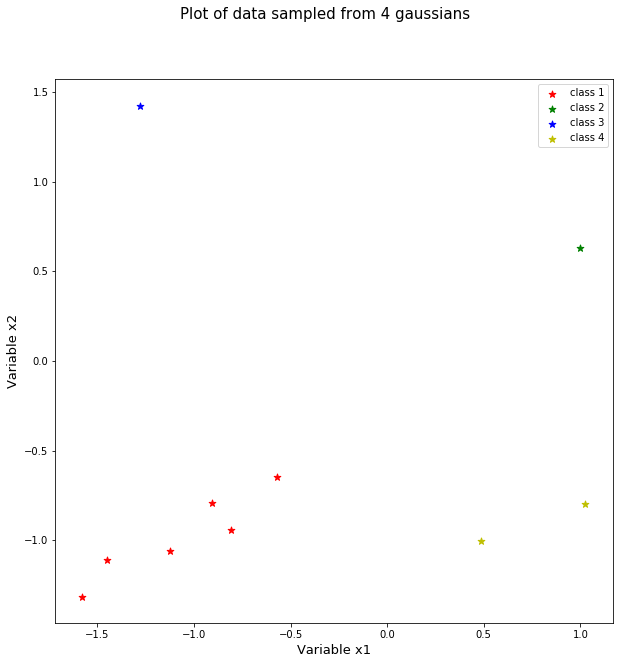

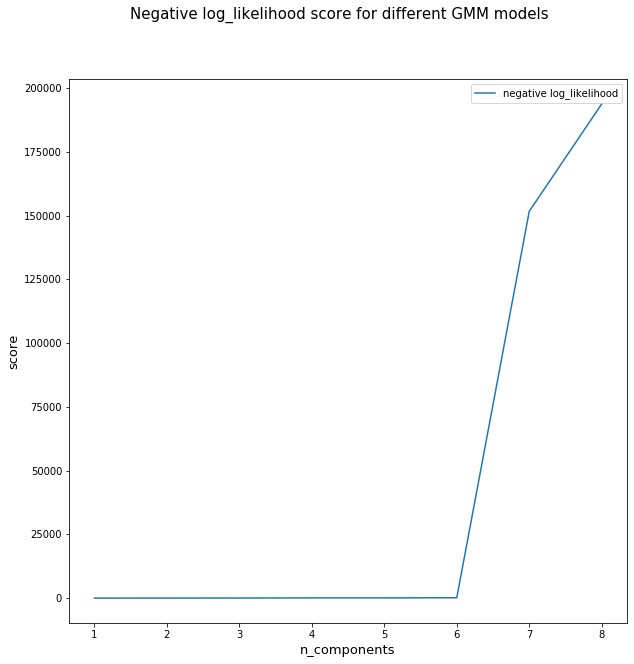

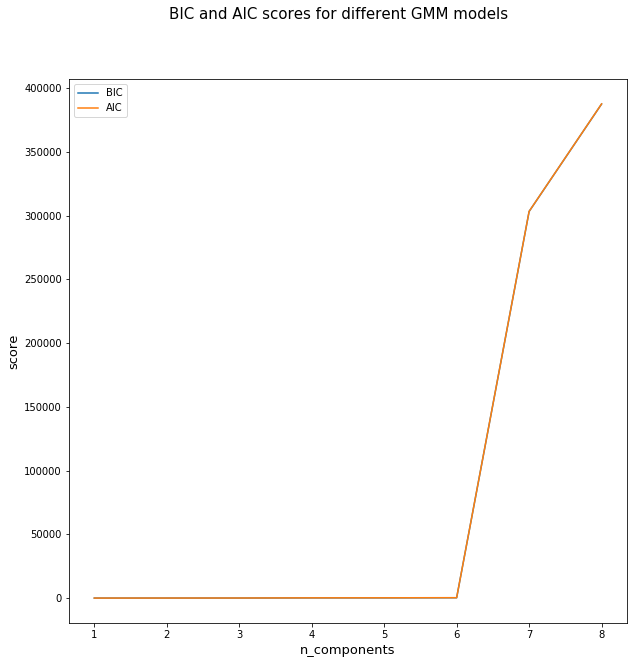




Number of samples:  100






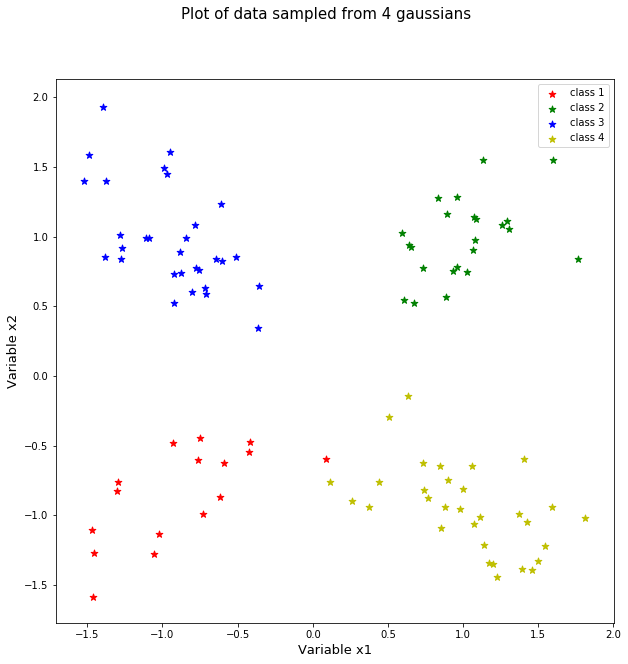

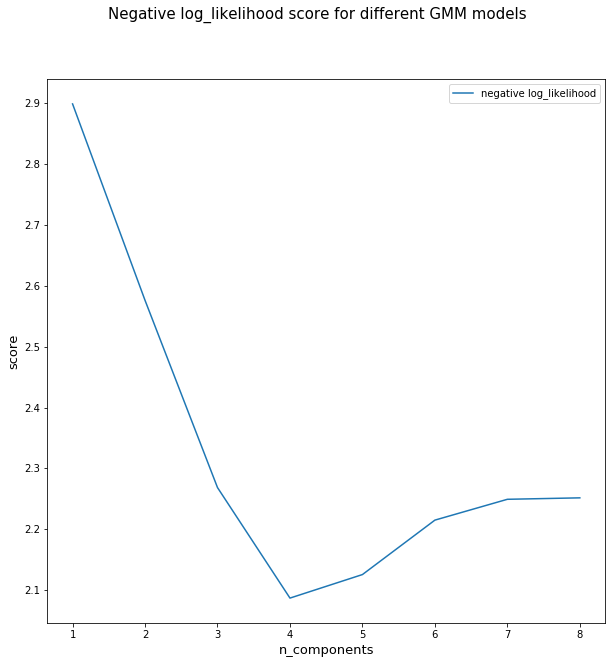

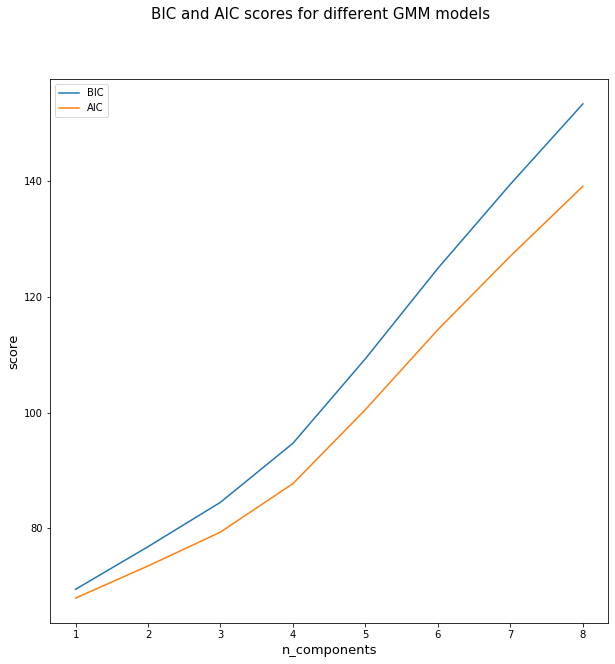




Number of samples:  1000






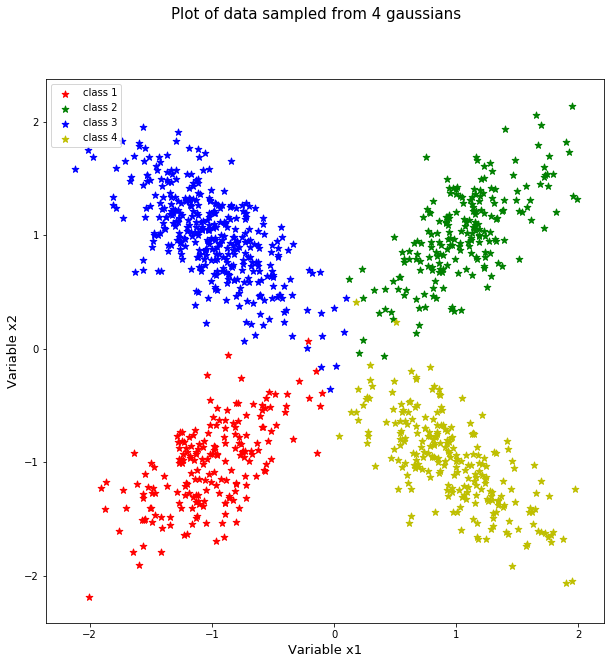

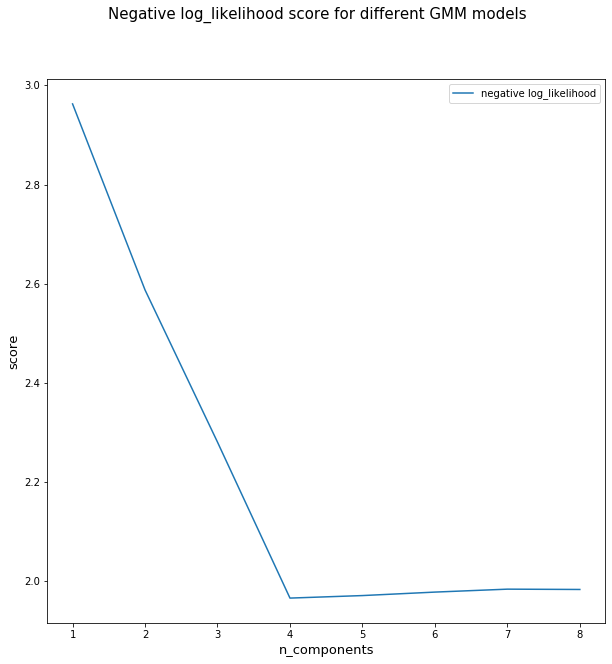

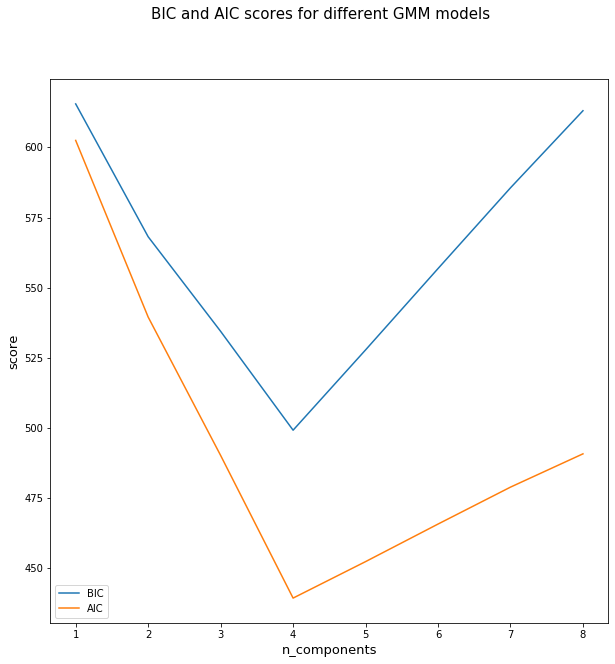




Number of samples:  10000






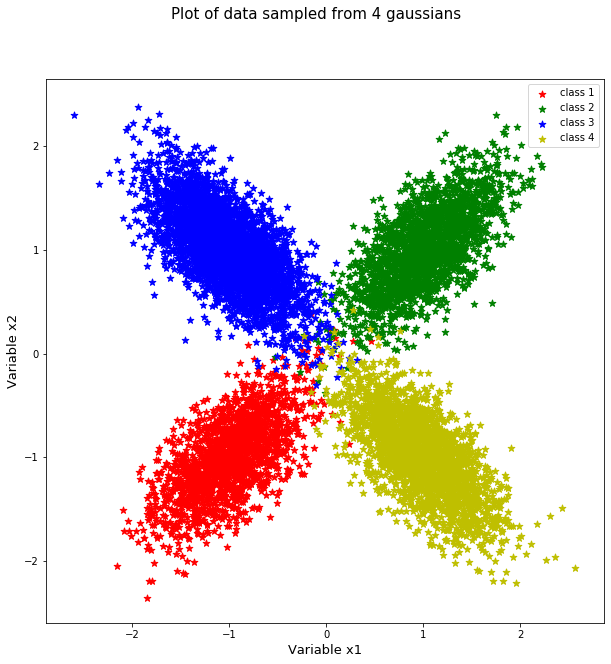

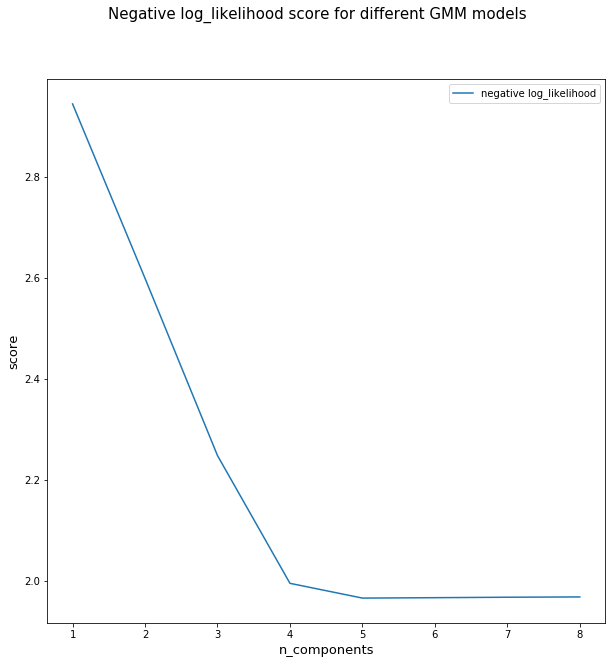

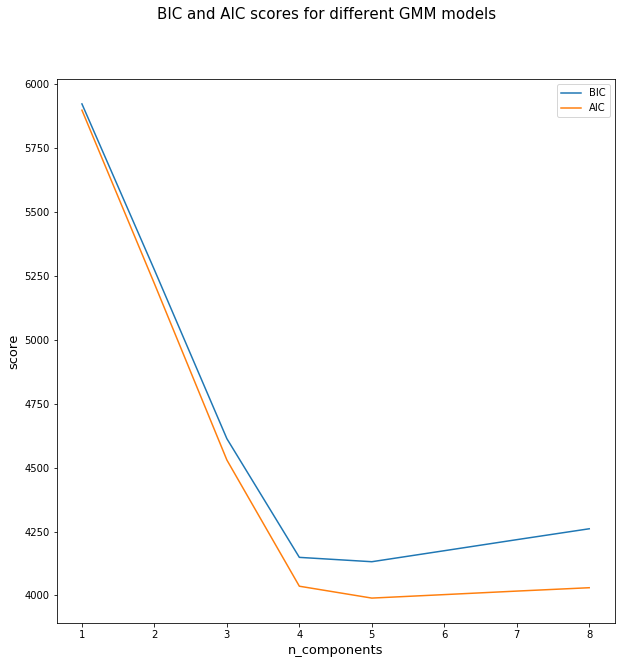

In [6]:
for i in [10,100, 1000, 10000]:
    print ("\n\n\nNumber of samples: ",i)
    data=generate_GMM_samples(prior=prior,number_of_samples=i,sig1=sig1,\
                     sig2=sig2,sig3=sig3,sig4=sig4,u1=u1,u2=u2,u3=u3,u4=u4);
    print ('\n\n\n')
    gmm_em_kfold(data)

### Conclusion

With number of samples=1000 or 10000, log likelihood and bic/aic indicate number of components = 4 is a good model for this data. 
Further, at n_components=4, the score quicly falls and plateaus around 4. Considering Occam's razor, number of components = 4 is clearly the best option

## Answer 2

In [7]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [8]:
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

In [24]:
def plot_data(lda, X, y, y_pred):
    plt.xlabel('Variable x1',size=13)
    plt.ylabel('Variable x2',size=13)
    fig.suptitle('LDA decision boundary for data from 2 Gaussians', fontsize=15)
    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1] # True Positive for class 0 and class 1 respectively
    # tp0 is boolean with "tp and class=0"
    X0, X1 = X[y == 0], X[y == 1] # points 
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')

    return 

In [25]:
def generate_GMM_samples_2class(prior,number_of_samples,sig1,sig2,u1,u2):
    '''
    Args:
    prior of class 1 = prior[0]
    prior of class 2 = 1-prior[0]

    
    number_of_samples
    
    class 1- u_1, sig_1
    class 2- u_2, sig_2

    
    x is samples from zero-mean identity-covariance Gaussian sample generators

    generating class 1- A1*x+b1
    generating class 2- A2*x+b2

    
    '''
    from matplotlib.pyplot import figure
    txt="Plot of data sampled from 4 gaussians "
    fig = plt.figure(figsize=(15,10));
    #fig.text(.35,0.09,txt,fontsize=15);
    
    samples_class1=[]
    samples_class2=[]

    
    sig_1=np.matrix(sig1)
    sig_2=np.matrix(sig2)

    
    u_1=np.matrix(u1).transpose()
    u_2=np.matrix(u2).transpose()
    
    prior=prior
    A1=np.linalg.cholesky(sig_1)
    b1=u_1

    A2=np.linalg.cholesky(sig_2)
    b2=u_2

    zero_mean=[0,0]
    cov=[[1,0],[0,1]]
    
    for i in range(number_of_samples):
        uniform_sample=np.random.uniform()

        sample_from_zero_mean_identity_covariance=np.random.multivariate_normal(zero_mean,cov,[1]).transpose()

        if uniform_sample<prior[0]:
            '''sample from class class 1'''
            sample=A1.dot(sample_from_zero_mean_identity_covariance)+b1
            samples_class1.append(sample)
        elif (prior[0]<uniform_sample<prior[0]+prior[1]):
            '''sample from class class 2'''
            sample=A2.dot(sample_from_zero_mean_identity_covariance)+b2
            samples_class2.append(sample)

    samples_class1_final=np.hstack(samples_class1)
    samples_class2_final=np.hstack(samples_class2)

    
    a=np.squeeze(np.asarray(samples_class1_final.transpose()[:,1]))
    b=np.squeeze(np.asarray(samples_class1_final.transpose()[:,0]))

    c=np.squeeze(np.asarray(samples_class2_final.transpose()[:,1]))
    d=np.squeeze(np.asarray(samples_class2_final.transpose()[:,0]))
    plt.xlabel('Variable x1',size=13)
    plt.ylabel('Variable x2',size=13)
    fig.suptitle('Data from 2 Gaussians', fontsize=15)
    plt.scatter(b,a,color='r',marker='*',label='class 1',s=50)
    plt.scatter(d,c,color='g',marker='*',label='class 2',s=50)
    X=np.hstack([samples_class1_final,samples_class2_final])
    plt.subplots_adjust(top=.95)
    y = np.hstack((np.zeros(samples_class1_final.shape[1]), np.ones(samples_class2_final.shape[1])))
    X=X.T
    X=np.squeeze(np.asarray(X))
    return X,y

### True GMM

In [26]:
prior=[0.3,0.7]  
# prior of Gaussian 1 = prior[0]
# prior of Gaussian 2 = prior[1]
# prior of Gaussian 3 = prior[2]
# prior of Gaussian 4 = prior[3]

# mean and covariance of gaussian 1
sig1=[[.15,.1],[-.1,.15]]
u1=[2,-1]

# mean and covariance of gaussian 2
sig2=[[.15,.1],[.1,.15]]
u2=[1,-1]

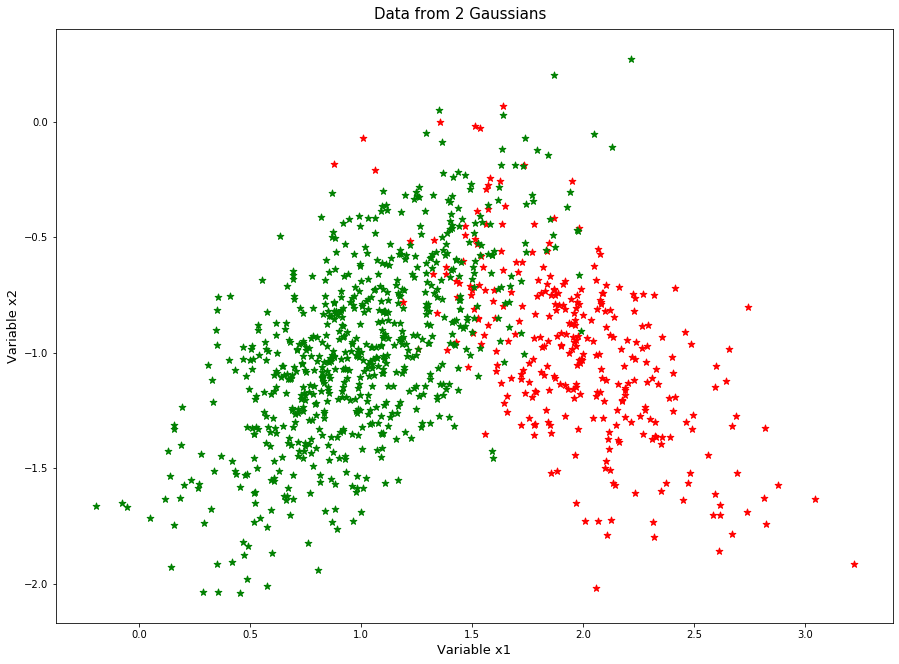

In [27]:
X,y=generate_GMM_samples_2class(prior=prior,number_of_samples=999,sig1=sig1,sig2=sig2,\
                                u1=u1,u2=u2);

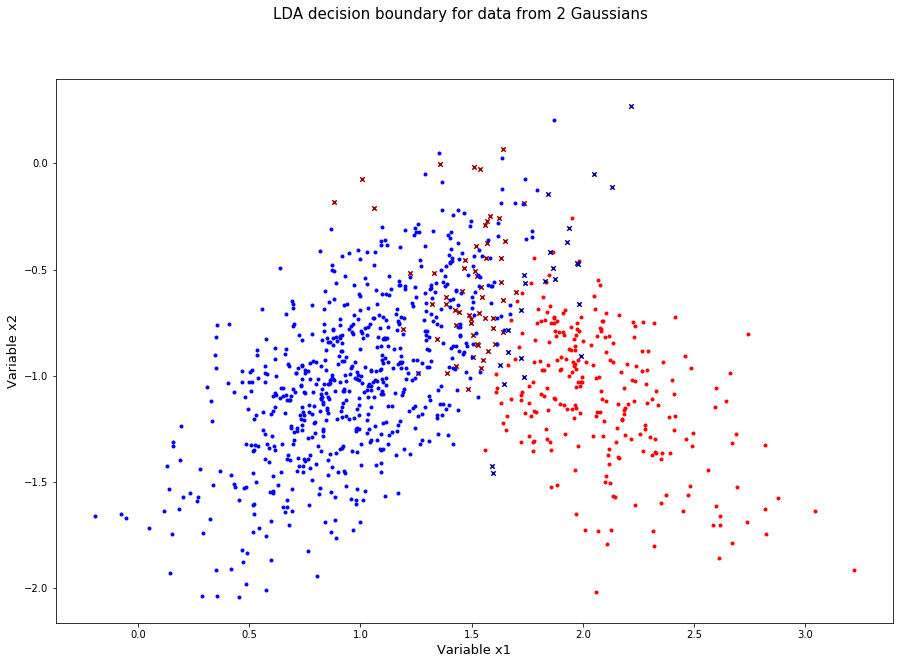

In [42]:
from matplotlib.pyplot import figure
fig = plt.figure(figsize=(15,10));
plt.xlabel('Variable x1',size=13)
plt.ylabel('Variable x2',size=13)
fig.suptitle('LDA decision boundary for data from 2 Gaussians', fontsize=15)
# y.shape=(999,)
# y_pred.shape=(999,)
tp = (y == y_pred)  # True Positive. tp.shape=(999,)

# class 0 has 0.3 prior and class 1 has .7 prior
# samples of class 10 = 308 (example)

# True Positive for class 0 and class 1 respectively
tp0=tp[y == 0]
# tp0.shape=(308,) tp0 has true and false classifications only for class 0

tp1= tp[y == 1] # tp1.shape=(691,)
X0, X1 = X[y == 0], X[y == 1] # points in X with class 0 and 1. shapes are 308 and 691 respect.
X0_tp, X0_fp = X0[tp0], X0[~tp0] # self explanatory
X1_tp, X1_fp = X1[tp1], X1[~tp1]
# class 0: dots
plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
            s=20, color='#990000')  # dark red

# class 1: dots
plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
            s=20, color='#000099')  # dark blue
# class 0 and 1 : areas
nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

In [ ]:
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
               norm=colors.Normalize(0., 1.), zorder=0)
plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

# means
plt.plot(lda.means_[0][0], lda.means_[0][1],
         '*', color='yellow', markersize=15, markeredgecolor='grey')
plt.plot(lda.means_[1][0], lda.means_[1][1],
         '*', color='yellow', markersize=15, markeredgecolor='grey')

return 

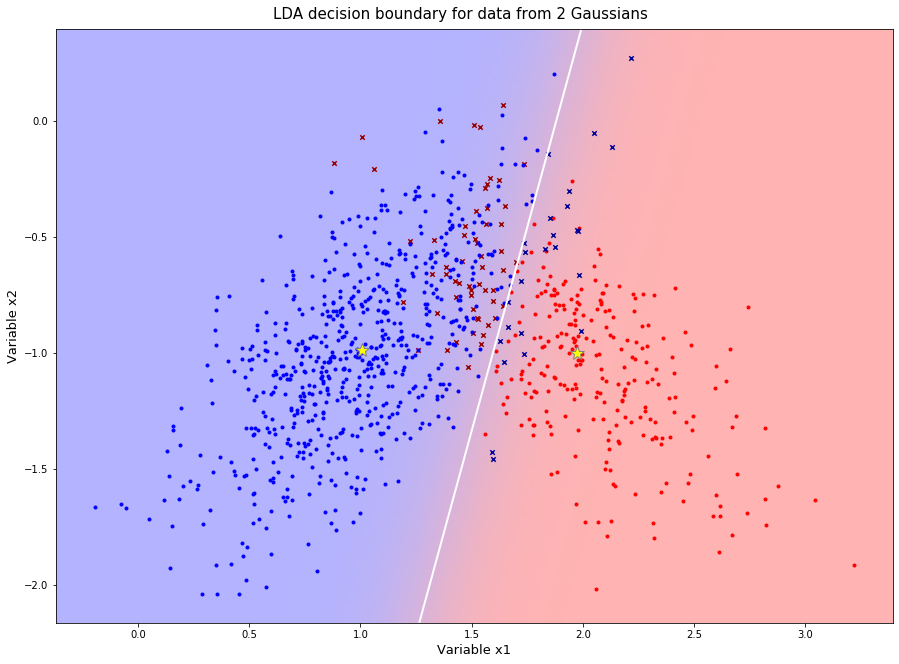

In [41]:
from matplotlib.pyplot import figure
fig = plt.figure(figsize=(15,10));
fig.suptitle('Linear Discriminant Analysis', fontsize=15)
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X, y)
y_pred = lda.predict(X)
plot_data(lda, X, y, y_pred)
plt.subplots_adjust(top=.95)
plt.show()

### LDA coefficients

In [259]:
lda.predict(X).reshape(-1,1);

In [260]:
w=lda.coef_.T
w

array([[-7.2498549 ],
       [ 2.13701792]])

In [261]:
b=lda.intercept_
b

array([13.76578784])

In [262]:
# Predict- ((np.matmul(X,lda.coef_.T)+ lda.intercept_)>0).astype(int)

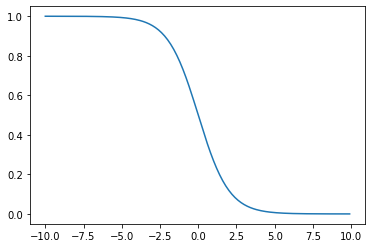

In [263]:
def test_logistic_function(x):
    return 1/(1+np.exp(x))
x=np.arange(-10,10,.1)
plt.plot(x,test_logistic_function(x));

![](./1.png)
![](./2.png)

In [264]:
# Add scalar 1 to feature vector

X=np.hstack([X,np.matrix(np.ones(999)).T])

In [291]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [287]:
def logistic_function(x,w1,w2,b):
    '''
    X.shape=(999,3)
    w.shape=3,1
    X is close to zero mean and close to unit std.
    Return: (999,)
    '''
    w=np.matrix([w1,w2,b])
    print (w.shape)
    print (x.shape)
    scalar=np.matmul(x,w.T)
    print (scalar.shape)
    output=1/(1+np.exp(scalar))
    print (output.shape)
    return output

In [288]:
from scipy.optimize import minimize

In [289]:
def cost(w):
    w1=w[0]
    w2=w[1]
    b=w[2]
    tmp1=np.log(logistic_function(X,w1,w2,b))
    tmp2=np.log(1-logistic_function(X,w1,w2,b))
    print (y.shape)
    print (tmp1.shape)
    return (y*tmp1+(1-y)*tmp2).sum()

In [290]:
w=np.array([-7.00396171,1.66208672,13.03809959])
cost(w)

(1, 3)
(999, 3)
(999, 1)
(999, 1)
(1, 3)
(999, 3)
(999, 1)
(999, 1)
(999,)
(999, 1)


-4010.328881669414

In [313]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            loss = self.__loss(h, y)
                
            if(self.verbose ==True and i % 10000 == 0):
                print(f'loss: {loss} \t')
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        return self.predict_prob(X).round()

In [319]:
model = LogisticRegression(lr=0.1, num_iter=300000)

In [320]:
X=np.squeeze(np.asarray(X))
model.fit(X, y)

In [321]:
preds = model.predict(X)
(preds == y).mean()

0.913913913913914

In [322]:
model.theta

array([10.81380972, -6.67336778,  0.19084709])

In [308]:
X=np.squeeze(np.asarray(X))

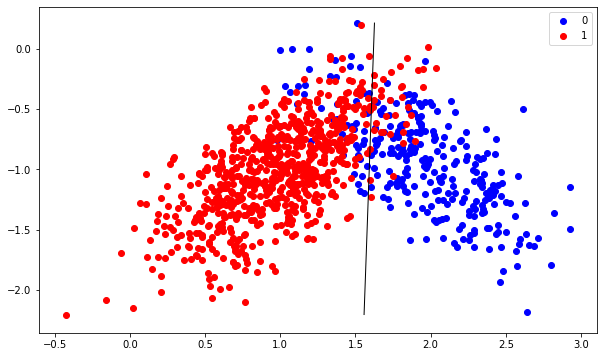

In [328]:
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
plt.legend()
x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
grid = np.c_[xx1.ravel(), xx2.ravel()]
probs = model.predict_prob(grid).reshape(xx1.shape)
plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black');